In [14]:
import os
import pandas as pd
import numpy as np
import re
import pathlib, warnings
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from gensim.models import LdaModel
from gensim import corpora
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
import spacy
import seaborn as sns
from wordcloud import WordCloud
from tqdm.auto import tqdm

nlp = spacy.load("en_core_web_sm")
stopwords_en = set(stopwords.words("english"))
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 110

In [16]:
def split_chunks(text: str, chunk_size: int = 100000):
    words = text.split()
    for i in range(0, len(words), chunk_size):
        yield " ".join(words[i : i + chunk_size])

def lemmatize(text: str):
    lemmas = []
    for chunk in split_chunks(text):
        doc = nlp(chunk)
        lemmas.extend(
            tok.lemma_.lower()
            for tok in doc
            if tok.is_alpha
            and len(tok.lemma_) > 2
            and tok.lemma_.lower() not in stopwords_en
        )
    return lemmas

In [17]:
df_republicans = pd.read_csv("breitbart.csv", usecols=["text"]).dropna().reset_index(drop=True)
df_dem_1 = pd.read_csv("commondreams.csv", usecols=["text"]).dropna().reset_index(drop=True)
df_dem_2 = pd.read_csv("motherjones.csv", usecols=["text"]).dropna().reset_index(drop=True)
df_democrats = pd.concat([df_dem_1, df_dem_2], ignore_index=True)

In [19]:
tqdm.pandas(desc="Lemmatizing republicans")
df_republicans["lemmas"] = df_republicans["text"].progress_apply(lemmatize)

tqdm.pandas(desc="Lemmatizing democrats")
df_democrats["lemmas"] = df_democrats["text"].progress_apply(lemmatize)

Lemmatizing republicans:   0%|          | 0/1075 [00:00<?, ?it/s]

Lemmatizing democrats:   0%|          | 0/799 [00:00<?, ?it/s]

In [20]:
# Составление словаря для модели
all_lemmas = df_republicans["lemmas"].tolist() + df_democrats["lemmas"].tolist()

dictionary = corpora.Dictionary(all_lemmas)
print(dictionary) 

Dictionary<27109 unique tokens: ['acceptable', 'age', 'also', 'amendment', 'america']...>


In [30]:
# Сначала подберем оптимальное количество тем на основе perplexity and coherence
corpus = [dictionary.doc2bow(lem_letter) for lem_letter in all_lemmas]

coherences = []
perplexities = []

for k in range(5, 50):
    lda_k = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        passes=10
    )
    
    cm = CoherenceModel(model=lda_k, texts=all_lemmas, dictionary=dictionary, coherence='c_v')
    coherence = cm.get_coherence()
    perplexity = np.exp2(-lda_k.log_perplexity(corpus))
    
    coherences.append(coherence)
    perplexities.append(perplexity)

    print(f"{k} тем: когерентность = {coherence:.4f}, перплексия = {perplexity:.2f}")

5 тем: когерентность = 0.3646, перплексия = 203.22
6 тем: когерентность = 0.3768, перплексия = 200.10
7 тем: когерентность = 0.3866, перплексия = 193.07
8 тем: когерентность = 0.3978, перплексия = 189.49
9 тем: когерентность = 0.3966, перплексия = 186.45
10 тем: когерентность = 0.3906, перплексия = 185.50
11 тем: когерентность = 0.3891, перплексия = 183.14
12 тем: когерентность = 0.3995, перплексия = 181.01
13 тем: когерентность = 0.4472, перплексия = 175.49
14 тем: когерентность = 0.4389, перплексия = 175.22
15 тем: когерентность = 0.4421, перплексия = 174.19
16 тем: когерентность = 0.4528, перплексия = 172.30
17 тем: когерентность = 0.4436, перплексия = 172.25
18 тем: когерентность = 0.4657, перплексия = 172.06
19 тем: когерентность = 0.4330, перплексия = 173.55
20 тем: когерентность = 0.4425, перплексия = 172.82
21 тем: когерентность = 0.4542, перплексия = 173.17
22 тем: когерентность = 0.4281, перплексия = 176.87
23 тем: когерентность = 0.4486, перплексия = 174.28
24 тем: когерентн

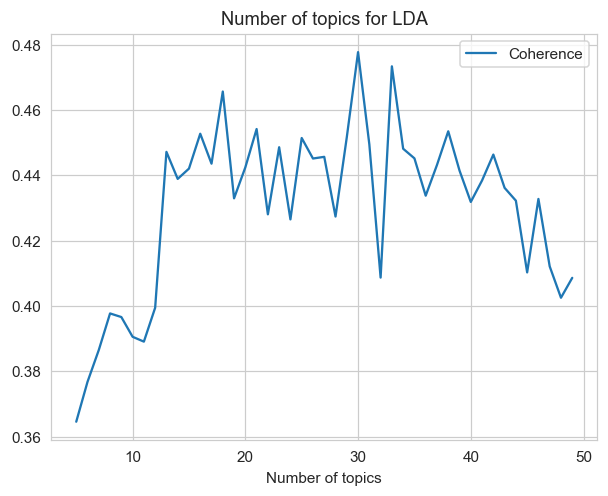

In [32]:
plt.plot(range(5, 50), coherences, label='Coherence')
plt.xlabel("Number of topics")
plt.legend()
plt.grid(True)
plt.title("Number of topics for LDA")
plt.show()

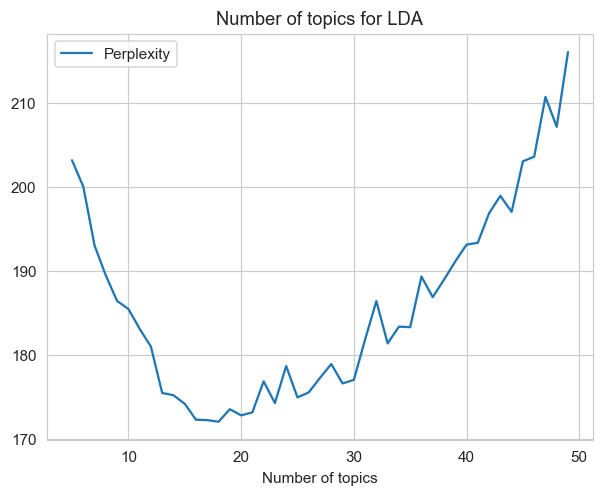

In [34]:
plt.plot(range(5, 50), perplexities, label='Perplexity')
plt.xlabel("Number of topics")
plt.legend()
plt.grid(True)
plt.title("Number of topics for LDA")
plt.show()

In [35]:
# Обучение модели LDA
lda_model = LdaModel(
    corpus=corpus,
    num_topics=18,
    id2word=dictionary,
    passes=10,
    random_state=42
)

In [36]:
for num, topic in lda_model.print_topics(-1):
    print(f'Тема {num}: {topic}')

Тема 0: 0.017*"bill" + 0.016*"war" + 0.016*"trump" + 0.013*"iran" + 0.011*"crypto" + 0.011*"senate" + 0.009*"president" + 0.009*"vote" + 0.008*"wednesday" + 0.008*"support"
Тема 1: 0.008*"news" + 0.008*"trump" + 0.006*"breitbart" + 0.006*"also" + 0.006*"gaza" + 0.006*"hamas" + 0.005*"say" + 0.005*"attack" + 0.005*"aid" + 0.005*"available"
Тема 2: 0.199*"library" + 0.143*"media" + 0.057*"medium" + 0.025*"june" + 0.022*"wlxvckv" + 0.017*"protest" + 0.014*"king" + 0.013*"trump" + 0.012*"getty" + 0.011*"image"
Тема 3: 0.024*"israel" + 0.023*"iran" + 0.013*"israeli" + 0.011*"air" + 0.010*"missile" + 0.009*"war" + 0.009*"iranian" + 0.009*"say" + 0.009*"force" + 0.008*"military"
Тема 4: 0.018*"kitchen" + 0.013*"student" + 0.013*"say" + 0.008*"free" + 0.007*"red" + 0.007*"states" + 0.007*"administration" + 0.006*"united" + 0.006*"international" + 0.006*"detain"
Тема 5: 0.024*"say" + 0.018*"mamdani" + 0.013*"state" + 0.011*"candidate" + 0.010*"antisemitism" + 0.010*"jewish" + 0.009*"new" + 0.00

In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.075141 -0.042597       1        1  14.648416
14    -0.108129 -0.038125       2        1  11.432380
9     -0.051078 -0.112157       3        1   8.831390
15     0.021626  0.150342       4        1   6.667954
0      0.019373  0.162438       5        1   6.365672
12     0.072178  0.214159       6        1   5.594266
13    -0.016579  0.007431       7        1   5.206483
2      0.419362 -0.159899       8        1   4.760326
6     -0.087901 -0.052262       9        1   4.755830
3     -0.002962  0.115076      10        1   4.731521
4      0.073454 -0.085872      11        1   4.572642
1     -0.052296 -0.044276      12        1   4.449584
5      0.034541 -0.032220      13        1   3.817983
16    -0.093143 -0.037653      14        1   3.684007
17    -0.093897 -0.047064      15        1   3.185636
11     0.077950  0.182396      16        1   2.881372
10    -0.090080 -0.057992      17        1   2.538627
7     -0.047279 -0.121724      18        1   1.875911, topic_info=                 Term         Freq        Total Category  logprob  loglift
15416         library  6547.000000  6547.000000  Default  30.0000  30.0000
3827            media  4720.000000  4720.000000  Default  29.0000  29.0000
289              iran  3608.000000  3608.000000  Default  28.0000  28.0000
921            medium  2636.000000  2636.000000  Default  27.0000  27.0000
291            israel  2916.000000  2916.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
918               man    45.609031   593.718169  Topic18  -5.6466   1.4098
512             child    43.016790   708.436714  Topic18  -5.7051   1.1746
394           country    47.878022  1584.187086  Topic18  -5.5981   0.4769
145    administration    49.792807  2592.908491  Topic18  -5.5588   0.0234
408        government    42.872474  2003.949183  Topic18  -5.7085   0.1314

[1438 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
17515     10  0.965598  abnormal
4965       1  0.103825  abortion
4965       2  0.007416  abortion
4965       9  0.003708  abortion
4965      12  0.003708  abortion
...      ...       ...       ...
5892      14  0.004712   zionist
5892      15  0.004712   zionist
5043      13  0.984233    zohran
5043      16  0.008867    zohran
17514      7  0.972086     zoley

[6797 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 15, 10, 16, 1, 13, 14, 3, 7, 4, 5, 2, 6, 17, 18, 12, 11, 8])

In [61]:
doc_topic = np.array([
    [prob for _, prob in lda_model.get_document_topics(bow, minimum_probability=0)]
    for bow in corpus
])  

rep_mat = doc_topic[:len(df_republicans)]
dem_mat = doc_topic[len(df_democrats):]

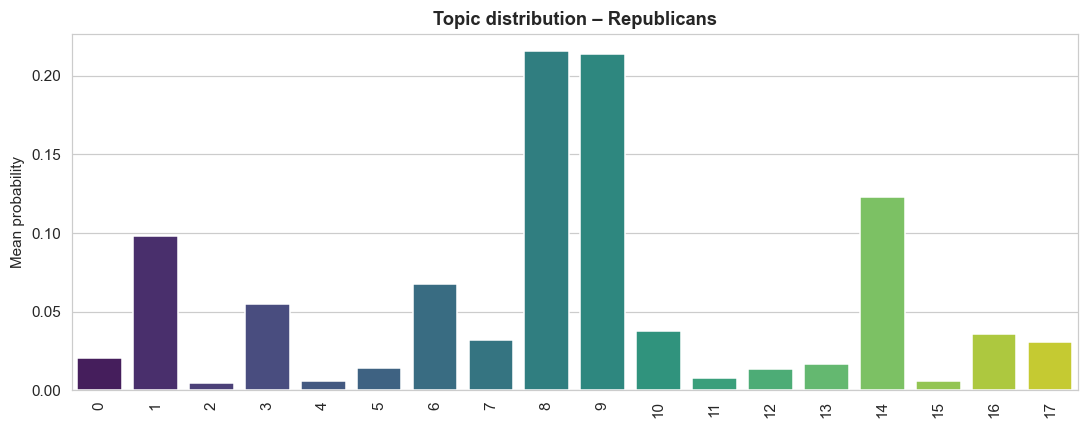

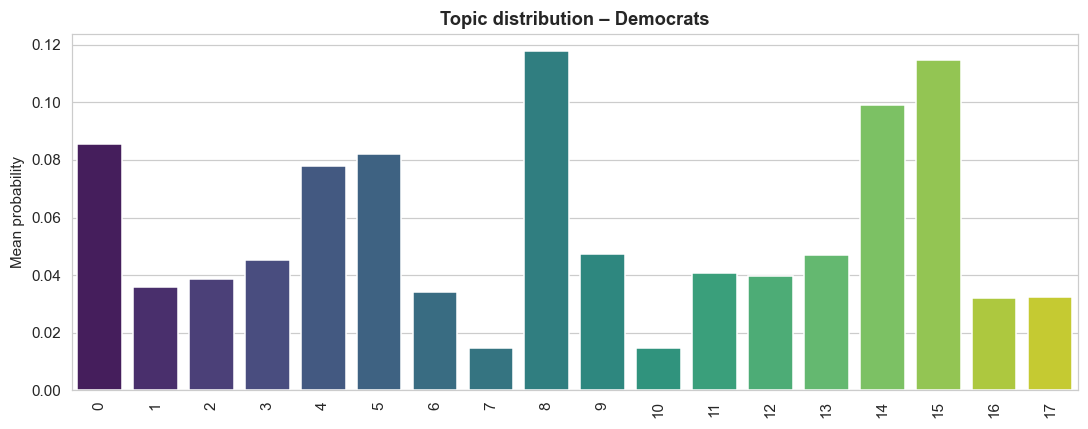

In [62]:
for label, mat, fname in [
    ("Republicans", rep_mat, "mean_R.png"),
    ("Democrats",   dem_mat, "mean_D.png")
]:
    plt.figure(figsize=(10, 4))
    sns.barplot(x=np.arange(18), y=mat.mean(axis=0), palette="viridis")
    plt.xticks(rotation=90)
    plt.ylabel("Mean probability")
    plt.title(f"Topic distribution – {label}", weight="bold")
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

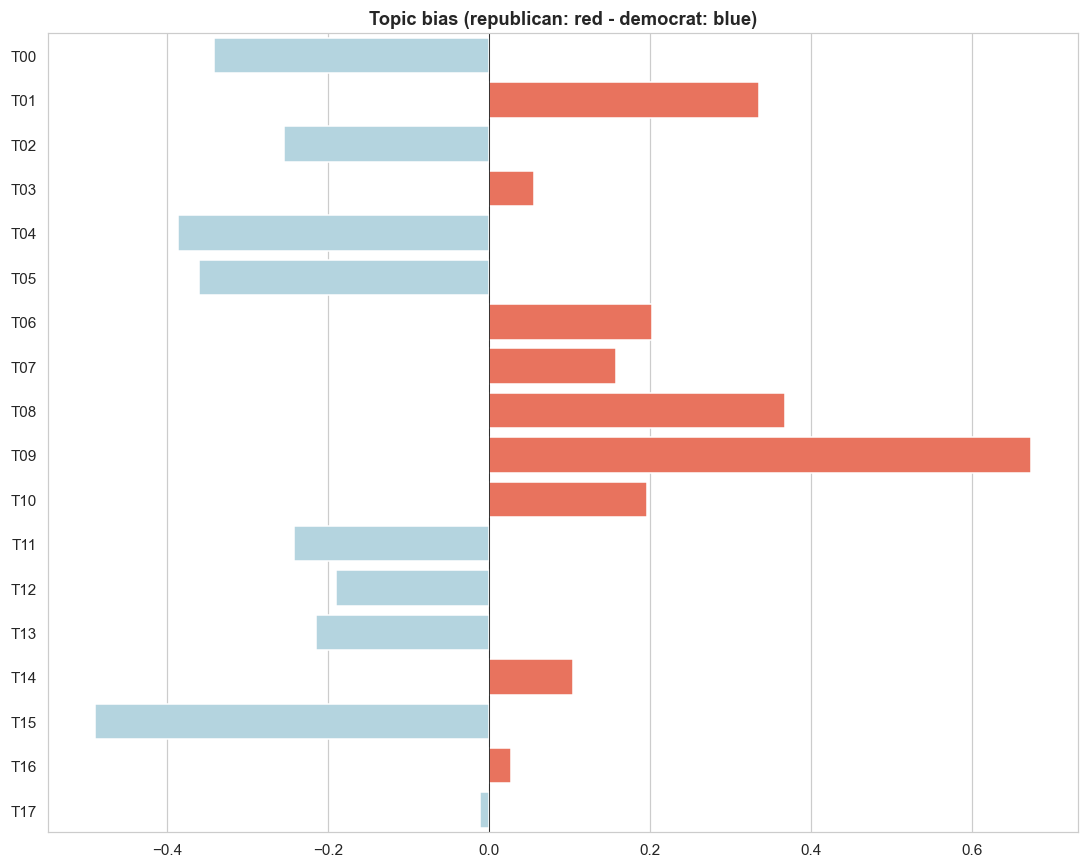

In [63]:
chi_score = (rep_mat.mean(axis=0) - dem_mat.mean(axis=0)) / \
            np.sqrt((rep_mat.var(axis=0) + dem_mat.var(axis=0)) / 2 + 1e-6)

colors = ['tomato' if score > 0 else 'lightblue' for score in chi_score]

plt.figure(figsize=(10, 8))
sns.barplot(
    x=chi_score,
    y=[f"T{t:02d}" for t in range(len(chi_score))],
    palette=colors,
    orient="h"
)
plt.axvline(0, color="k", lw=.5)
plt.title("Topic bias (republican: red - democrat: blue)", weight="bold")
plt.tight_layout()
plt.show()

In [65]:
topic_shift = rep_mat.mean(axis=0) - dem_mat.mean(axis=0)
rep_idx = topic_shift.argsort()[-4:][::-1]
dem_idx = topic_shift.argsort()[:4]

for tid in rep_idx:
  wc = WordCloud(width=600, height=400, background_color="white", colormap="Oranges")
  wc.generate_from_frequencies(dict(lda_model.show_topic(tid, topn=50))).to_file(f"plots/R_{tid:02d}.png")

for tid in dem_idx:
  wc = WordCloud(width=600, height=400, background_color="white", colormap="Blues")
  wc.generate_from_frequencies(dict(lda_model.show_topic(tid, topn=50))).to_file(f"plots/D_{tid:02d}.png")